In [5]:
from pathlib import Path

from openmc.deplete import CoupledOperator
import openmc
from openmc.deplete import MsrContinuous
import numpy as np 

CHAIN_PATH = "chain_simple.xml"

In [6]:
def model():
    fuel = openmc.Material(name="uo2", material_id=1)
    fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
    fuel.add_element("O", 2)
    fuel.set_density("g/cc", 10.4)

    clad = openmc.Material(name="clad", material_id=2)
    clad.add_element("Zr", 1)
    clad.set_density("g/cc", 6)

    water = openmc.Material(name="water", material_id=3)
    water.add_element("O", 1)
    water.add_element("H", 2)
    water.set_density("g/cc", 1.0)
    water.add_s_alpha_beta("c_H_in_H2O")
    water.depletable = True

    radii = [0.42, 0.45]
    fuel.volume = np.pi * radii[0] ** 2
    clad.volume = np.pi * (radii[1]**2 - radii[0]**2)
    water.volume = 1.24**2 - (np.pi * radii[1]**2)

    materials = openmc.Materials([fuel, clad, water])

    pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
    pin_univ = openmc.model.pin(pin_surfaces, materials)
    bound_box = openmc.rectangular_prism(1.24, 1.24, boundary_type="reflective")
    root_cell = openmc.Cell(fill=pin_univ, region=bound_box)
    geometry = openmc.Geometry([root_cell])

    settings = openmc.Settings()
    settings.particles = 1000
    settings.inactive = 10
    settings.batches = 50

    return openmc.Model(geometry, materials, settings)

In [7]:
def test_msr_transfer(model, removal_rate, times, power):
    
    op = CoupledOperator(model, CHAIN_PATH)
    msr = MsrContinuous(op, model)
    msr.set_removal_rate('uo2', ['U'], removal_rate, dest_mat='water')
    integrator = openmc.deplete.PredictorIntegrator(
        op, times, power, msr_continuous = msr, timestep_units = 'd')
    integrator.integrate()

    results = openmc.deplete.Results('depletion_results.h5')
    _, atoms = results.get_atoms(model.materials[0], "U238")
    return atoms

In [8]:
from math import exp

n0=model().materials[0].get_nuclide_atoms()['U238']
removal_rates = [0.0,0.0001,0.00001]
times = [1,1,1] #days
power = 0
openmc_msr_calc = []
back_of_envelop_calc = []
for i in removal_rates:
    _openmc_msr_calc = []
    _openmc_msr_calc.append(test_msr_transfer(model(), i, times, power))
    _back_of_envelop_calc = []
    _back_of_envelop_calc.append(n0)
    # Solving n=no*exp(-lambda*t)
    for t in np.cumsum(times):
        _n0 = n0
        t_in_sec = t*3600*24
        n = _n0*exp(-i*t_in_sec)
        _back_of_envelop_calc.append(n)
        _n0 = n
    openmc_msr_calc.append(_openmc_msr_calc)
    back_of_envelop_calc.append(_back_of_envelop_calc)

/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=1.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=2.
  warn(msg, IDWarning)
/home/lorenzo/openmc/openmc/openmc/mixin.py:70: IDWarning: Another Material instance already exists with id=3.
  warn(msg, IDWarning)


                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Creating state point openmc_simulation_n0.h5...
Timestep: 0 --> keff: 0.00000
[openmc.deplete] t=86400.0 s, dt=86400 s, source=0
 Creating state point openmc_simulation_n1.h5...
Timestep: 1 --> keff: 0.00000
[openmc.deplete] t=172800.0 s, dt=86400 s, source=0
 Creating state point openmc_simulation_n2.h5...
Timestep: 2 --> keff: 0.00000
[openmc.deplete] t=259200.0 (final operator evaluation)
 Creating state point openmc_simulation_n3.h5...
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%

 Minimum neutron data temperature: 0 K
 Maximum neutron data temperature: 1.7976931348623157e+308 K
 Preparing distributed cell instances...
 Reading plot XML file...
 Writing summary.h5 file...
[openmc.deplete] t=0.0 s, dt=86400 s, source=0
 Reading I135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/I135.h5
 Reading Xe135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe135.h5
 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Creating state point openmc_simulation_n0.h5...
Timestep: 0 --> keff: 0.00000
[openmc.deplete] t=86400.0 s, dt=86400 s, source=0
 Creating state point openmc_simulation_n1.h5...
Timestep: 1 --> keff: 0.00000
[openmc.deplete] t=172800.0 s, dt=86400 s, source=0
 Creating sta

 Reading Xe136 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Xe136.h5
 Reading Cs135 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Cs135.h5
 Reading Gd157 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd157.h5
 Reading Gd156 from /home/lorenzo/Documents/cross_sections/endfb80_hdf5/Gd156.h5
 Creating state point openmc_simulation_n0.h5...
Timestep: 0 --> keff: 0.00000
[openmc.deplete] t=86400.0 s, dt=86400 s, source=0
 Creating state point openmc_simulation_n1.h5...
Timestep: 1 --> keff: 0.00000
[openmc.deplete] t=172800.0 s, dt=86400 s, source=0
 Creating state point openmc_simulation_n2.h5...
Timestep: 2 --> keff: 0.00000
[openmc.deplete] t=259200.0 (final operator evaluation)
 Creating state point openmc_simulation_n3.h5...


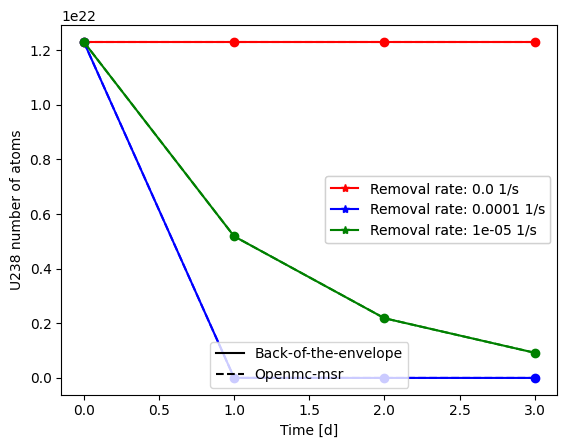

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import Line2D
line1 = Line2D([0], [0], color='black')
line2 = Line2D([0], [0], linestyle='--', color='black')
labels = ['Back-of-the-envelope', 'Openmc-msr']
colors = ['r','b','g']
fig, ax = plt.subplots()
for i in range(len(removal_rates)):
    ax.plot(np.append(0,np.cumsum(times)), back_of_envelop_calc[i] , marker='*', color=colors[i], label=f'Removal rate: {removal_rates[i]} 1/s')
    ax.plot(np.append(0,np.cumsum(times)), openmc_msr_calc[i][0] , '--', marker='o', color=colors[i])
leg1=plt.legend([line1, line2],labels,loc='lower center')
leg2=plt.legend(loc='center right')
ax.add_artist(leg1)
ax.add_artist(leg2)
ax.set_xlabel('Time [d]')
ax.set_ylabel('U238 number of atoms')
#ax.set_yscale('log')
plt.show()